In [1]:
import mlrose_hiive
import numpy as np
import time
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import ParameterGrid
from mlrose_hiive import ExpDecay
from mlrose_hiive import FourPeaks, mimic

In [2]:
# Set the random seed for reproducibility
np.random.seed(42)

problem_size = 15
fitness = mlrose_hiive.OneMax()
problem = mlrose_hiive.DiscreteOpt(length=problem_size, fitness_fn=fitness, maximize=True)

In [3]:
## 1. Randomized Hill Climbing (RHC):
# 1. Initialization
init_state = np.random.randint(2, size=problem_size)

# 2. Tuning Hyperparameters using GridSearch
param_grid = {
    'max_attempts': [10, 100],
    'max_iters': [500, 1000],
    'restarts': [5, 10]
}

best_fitness = -np.inf  # initialize with a very small value
best_params = {}

for params in ParameterGrid(param_grid):
    _, current_best_fitness, _ = mlrose_hiive.random_hill_climb(
        problem,
        init_state=init_state,
        curve=False,
        random_state=42,
        **params
    )
    
    if current_best_fitness > best_fitness:
        best_fitness = current_best_fitness
        best_params = params

print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'max_attempts': 100, 'max_iters': 500, 'restarts': 5}


Best State: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Best Fitness: 15.0


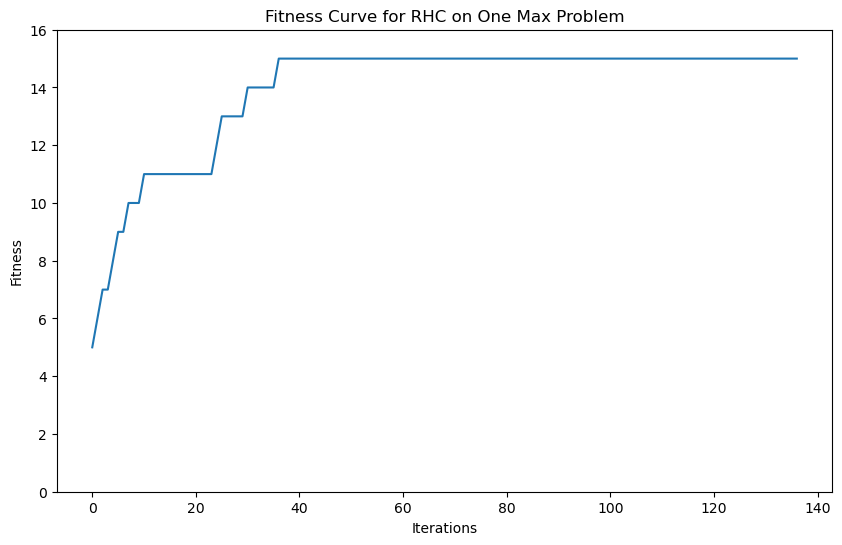

In [4]:
# 3. Run Algorithm with best parameters
best_state, best_fitness, fitness_curve = mlrose_hiive.random_hill_climb(
    problem,
    init_state=init_state,
    curve=True,
    random_state=42,
    **best_params
)

print(f"Best State: {best_state}")
print(f"Best Fitness: {best_fitness}")

# Extract fitness values from the fitness_curve
fitness_values = fitness_curve[:, 0]

# Plotting the fitness curve
plt.figure(figsize=(10,6))
plt.plot(fitness_values)
plt.title("Fitness Curve for RHC on One Max Problem")
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.ylim(0, 16)  # Setting y-axis limits to focus on the range [0, 16]
plt.show()

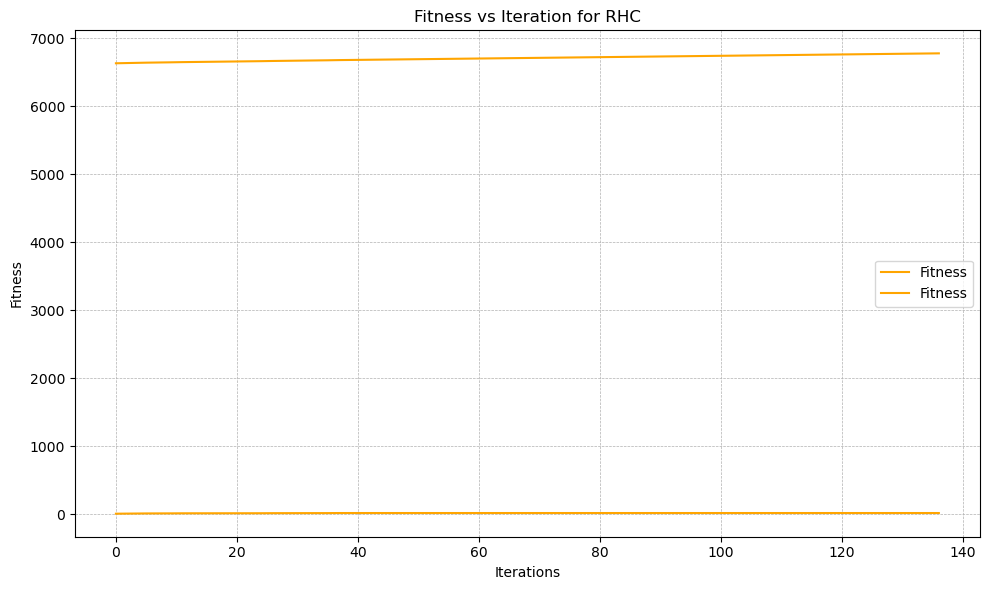

In [5]:
# Extracting the fitness values from the fitness_curve
fitness_values = fitness_curve

# Plotting the fitness curve
plt.figure(figsize=(10,6))
plt.plot(fitness_values, label="Fitness", color='orange')  # Using the color orange for consistency with your GA plot
plt.title("Fitness vs Iteration for RHC")
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adding a grid for better readability
plt.tight_layout()  # Adjusts the plot to fit the figure area better
plt.show()

In [13]:
print(f"Best Parameters: {best_params}")

Best Parameters: {'max_attempts': 100, 'max_iters': 500, 'restarts': 5}


In [14]:
print(fitness_curve[:10])  # prints the first 10 values

[[5.000e+00 6.630e+03]
 [6.000e+00 6.632e+03]
 [7.000e+00 6.634e+03]
 [7.000e+00 6.635e+03]
 [8.000e+00 6.637e+03]
 [9.000e+00 6.639e+03]
 [9.000e+00 6.640e+03]
 [1.000e+01 6.642e+03]
 [1.000e+01 6.643e+03]
 [1.000e+01 6.644e+03]]


In [5]:
# 4. Time Analysis
start_time = time.time()
mlrose_hiive.random_hill_climb(
    problem,
    init_state=init_state,
    curve=False,
    random_state=42,
    **best_params
)
end_time = time.time()
print(f"Time taken for RHC: {end_time - start_time:.5f} seconds")

Time taken for RHC: 0.02094 seconds


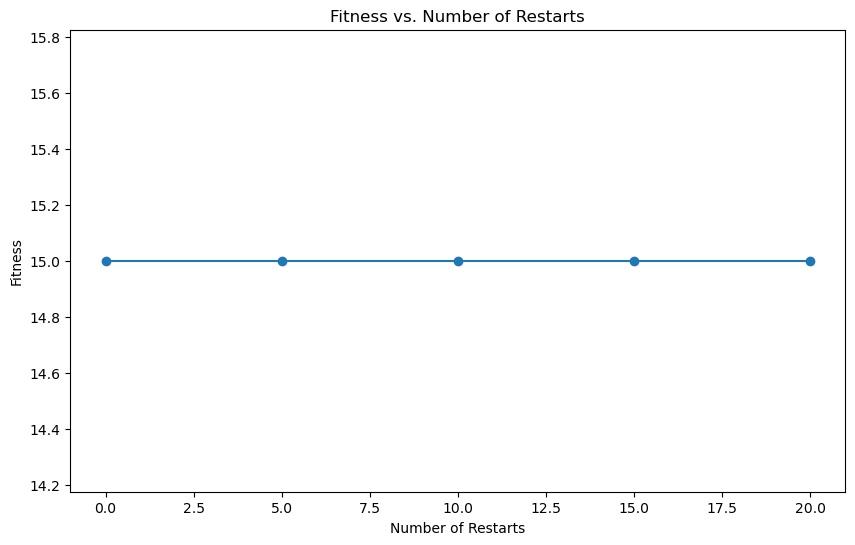

In [6]:
# 5. Restart Analysis
restarts_range = [0, 5, 10, 15, 20]
fitnesses = []

for restart in restarts_range:
    _, current_best_fitness, _ = mlrose_hiive.random_hill_climb(
        problem,
        init_state=init_state,
        curve=False,
        random_state=42,
        max_attempts=best_params['max_attempts'],
        max_iters=best_params['max_iters'],
        restarts=restart
    )
    fitnesses.append(current_best_fitness)

plt.figure(figsize=(10,6))
plt.plot(restarts_range, fitnesses, marker='o')
plt.title("Fitness vs. Number of Restarts")
plt.xlabel("Number of Restarts")
plt.ylabel("Fitness")
plt.show()

In [7]:
# 6. Consistency Check
num_runs = 10
results = []

for i in range(num_runs):
    _, best_fitness_run, _ = mlrose_hiive.random_hill_climb(
        problem, 
        init_state=None,
        curve=False,
        random_state=42 + i,
        **best_params
    )
    results.append(best_fitness_run)

print(f"Results across {num_runs} runs:")
print(f"Mean: {np.mean(results)}")
print(f"Median: {np.median(results)}")
print(f"Min: {np.min(results)}")
print(f"Max: {np.max(results)}")
print(f"Standard Deviation: {np.std(results)}")

Results across 10 runs:
Mean: 15.0
Median: 15.0
Min: 15.0
Max: 15.0
Standard Deviation: 0.0


In [8]:
# 7. Already done above with the fitness curve plot
# 8. Initial State Sensitivity
# It's similar to consistency check, but with varying initial states rather than random seeds.

results_init = []

for i in range(num_runs):
    random_init = np.random.randint(2, size=problem_size)
    _, best_fitness_run, _ = mlrose_hiive.random_hill_climb(
        problem,
        init_state=random_init,
        curve=False,
        random_state=42,
        **best_params
    )
    results_init.append(best_fitness_run)

print(f"Results with different initial states:")
print(f"Mean: {np.mean(results_init)}")
print(f"Median: {np.median(results_init)}")
print(f"Min: {np.min(results_init)}")
print(f"Max: {np.max(results_init)}")
print(f"Standard Deviation: {np.std(results_init)}")

Results with different initial states:
Mean: 15.0
Median: 15.0
Min: 15.0
Max: 15.0
Standard Deviation: 0.0


In [20]:
##SA
### 1. Initialization ###
init_temp = 1.0
decay = ExpDecay(init_temp)

### 2. Tuning Hyperparameters ###

# This is just an example. Depending on computational constraints, you might adjust these ranges.
temperatures = [0.1, 0.5, 1.0, 5.0, 10.0]
max_attempts_range = [10, 100]
max_iters_range = [500, 1000]

# Placeholder for the best parameters
best_fitness = -np.inf  # to ensure any fitness will be better
best_params = {}

for temp in temperatures:
    for max_attempts in max_attempts_range:
        for max_iters in max_iters_range:
            decay = ExpDecay(temp)
            _, current_fitness, _ = mlrose_hiive.simulated_annealing(
                problem,
                schedule=decay,
                max_attempts=max_attempts,
                max_iters=max_iters,
                random_state=42
            )

            if current_fitness > best_fitness:
                best_fitness = current_fitness
                best_params = {'temperature': temp, 'max_attempts': max_attempts, 'max_iters': max_iters}

print("Best Parameters:", best_params)

Best Parameters: {'temperature': 0.1, 'max_attempts': 10, 'max_iters': 500}


Best State: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Best Fitness: 15.0


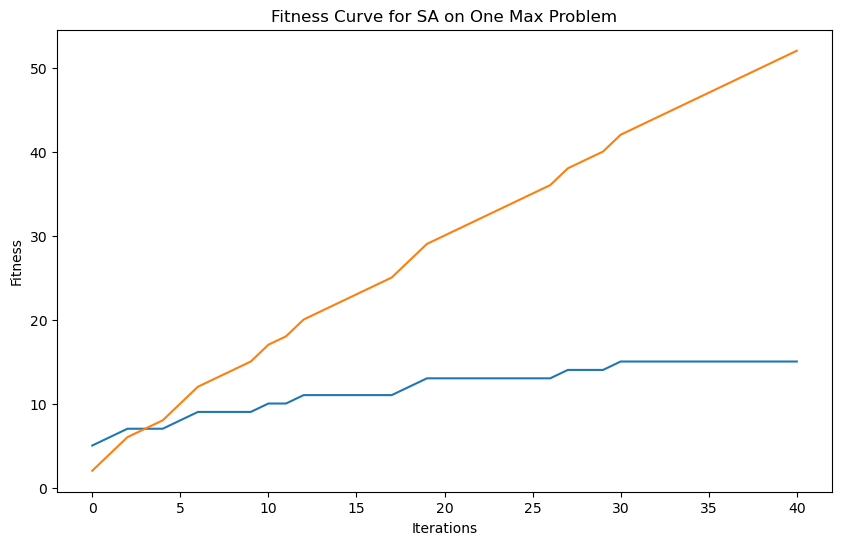

Execution Time: 0.0012559890747070312 seconds


In [21]:
### 3. Run Algorithm ###

# Using the best parameters from above
decay = ExpDecay(best_params['temperature'])

start_time = time.time()

best_state, best_fitness, fitness_curve = mlrose_hiive.simulated_annealing(
    problem,
    schedule=decay,
    max_attempts=best_params['max_attempts'],
    max_iters=best_params['max_iters'],
    curve=True,
    random_state=42
)

end_time = time.time()

print(f"Best State: {best_state}")
print(f"Best Fitness: {best_fitness}")

plt.figure(figsize=(10,6))
plt.plot(fitness_curve)
plt.title("Fitness Curve for SA on One Max Problem")
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.show()

### 4. Time Analysis ###

print(f"Execution Time: {end_time - start_time} seconds")

Results across 10 runs:
Mean: 13.3
Median: 13.5
Min: 11.0
Max: 15.0
Standard Deviation: 1.3453624047073711
Results with different initial states:
Mean: 13.2
Median: 13.0
Min: 13.0
Max: 14.0
Standard Deviation: 0.4


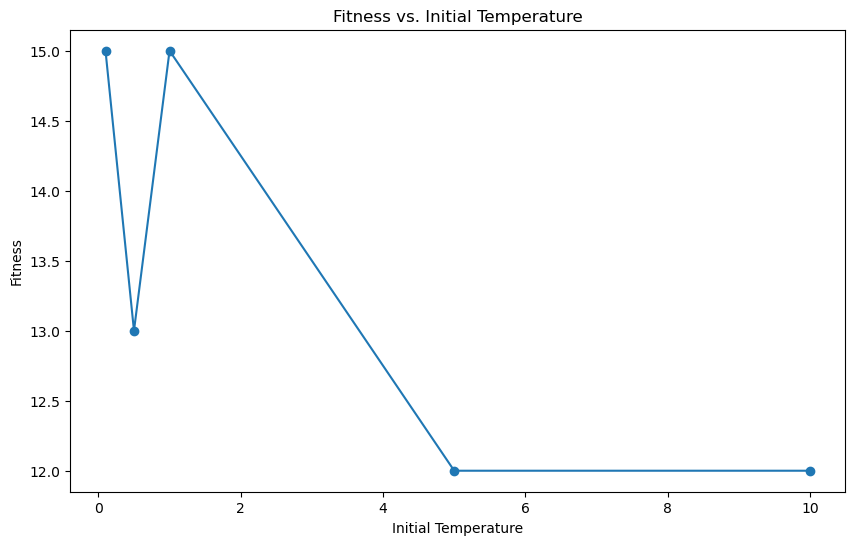

In [23]:
# 1. Consistency Across Runs
results = []

for i in range(num_runs):
    _, best_fitness_run, _ = mlrose_hiive.simulated_annealing(
        problem, 
        schedule=ExpDecay(best_params['temperature']),
        max_attempts=best_params['max_attempts'],
        max_iters=best_params['max_iters'],
        random_state=42 + i
    )
    results.append(best_fitness_run)

print(f"Results across {num_runs} runs:")
print(f"Mean: {np.mean(results)}")
print(f"Median: {np.median(results)}")
print(f"Min: {np.min(results)}")
print(f"Max: {np.max(results)}")
print(f"Standard Deviation: {np.std(results)}")

# 2. Consistency Across Different Initial States
results_init = []

for i in range(num_runs):
    random_init = np.random.randint(2, size=problem_size)
    _, best_fitness_run, _ = mlrose_hiive.simulated_annealing(
        problem,
        init_state=random_init,
        schedule=ExpDecay(best_params['temperature']),
        max_attempts=best_params['max_attempts'],
        max_iters=best_params['max_iters'],
        random_state=42
    )
    results_init.append(best_fitness_run)

print(f"Results with different initial states:")
print(f"Mean: {np.mean(results_init)}")
print(f"Median: {np.median(results_init)}")
print(f"Min: {np.min(results_init)}")
print(f"Max: {np.max(results_init)}")
print(f"Standard Deviation: {np.std(results_init)}")

# 3. Temperature Analysis
temperatures_range = [0.1, 0.5, 1.0, 5.0, 10.0]
fitnesses = []

for temp in temperatures_range:
    decay = ExpDecay(temp)
    _, current_best_fitness, _ = mlrose_hiive.simulated_annealing(
        problem,
        schedule=decay,
        max_attempts=best_params['max_attempts'],
        max_iters=best_params['max_iters'],
        random_state=42
    )
    fitnesses.append(current_best_fitness)

plt.figure(figsize=(10,6))
plt.plot(temperatures_range, fitnesses, marker='o')
plt.title("Fitness vs. Initial Temperature")
plt.xlabel("Initial Temperature")
plt.ylabel("Fitness")
plt.show()

Total Iterations: 41


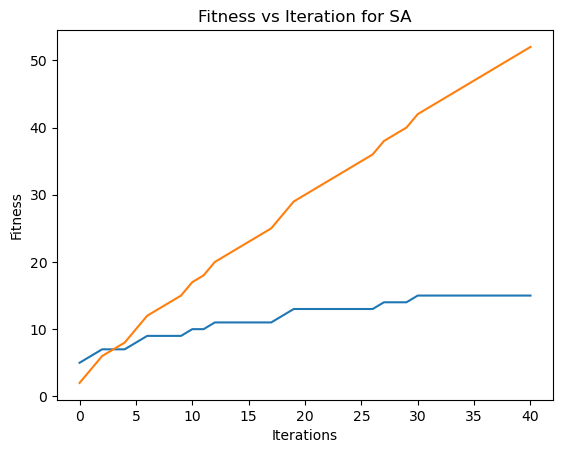

In [25]:
state, best_fitness, curve = mlrose_hiive.simulated_annealing(
    problem,
    schedule=mlrose_hiive.GeomDecay(init_temp=best_params["temperature"]),
    init_state=None,
    curve=True,
    random_state=42,
    max_attempts=best_params["max_attempts"],
    max_iters=best_params["max_iters"]
)

# Extract iteration counts
iteration_counts = len(curve)
print(f"Total Iterations: {iteration_counts}")

# Visualization of Fitness vs. Iteration
iterations = np.arange(iteration_counts)
plt.plot(iterations, curve)
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('Fitness vs Iteration for SA')
plt.show()

In [28]:
#GA
# Initial parameters for GA
population_sizes = [50, 100, 200, 400, 800]
mutation_probs = [0.01, 0.05, 0.1, 0.2, 0.3]

In [29]:
best_fitness = -np.inf
best_params = None

results = []
times = []

for pop in population_sizes:
    for mut in mutation_probs:
        start_time = time.time()
        _, best_fitness_run, _ = mlrose_hiive.genetic_alg(
            problem,
            pop_size=pop,
            mutation_prob=mut,
            random_state=42
        )
        end_time = time.time()
        times.append(end_time - start_time)
        
        if best_fitness_run > best_fitness:
            best_fitness = best_fitness_run
            best_params = {"pop_size": pop, "mutation_prob": mut}
        results.append((pop, mut, best_fitness_run))

print(f"Best fitness achieved: {best_fitness}")
print(f"Best parameters: {best_params}")

print(f"Average time taken: {np.mean(times)} seconds")

Best fitness achieved: 15.0
Best parameters: {'pop_size': 50, 'mutation_prob': 0.01}
Average time taken: 0.22982221603393554 seconds


In [30]:
# Results with different initial states
num_runs = 10
run_results = []

for i in range(num_runs):
    _, best_fitness_run, _ = mlrose_hiive.genetic_alg(
        problem,
        pop_size=best_params["pop_size"],
        mutation_prob=best_params["mutation_prob"],
        random_state=42 + i
    )
    run_results.append(best_fitness_run)

print(f"Results across {num_runs} runs:")
print(f"Mean: {np.mean(run_results)}")
print(f"Median: {np.median(run_results)}")
print(f"Min: {np.min(run_results)}")
print(f"Max: {np.max(run_results)}")
print(f"Standard Deviation: {np.std(run_results)}")

Results across 10 runs:
Mean: 15.0
Median: 15.0
Min: 15.0
Max: 15.0
Standard Deviation: 0.0


Number of iterations: 16


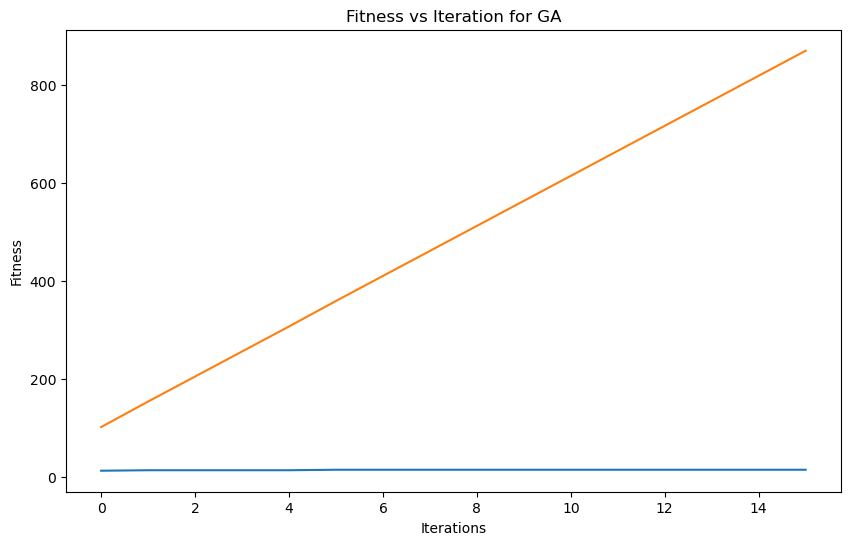

In [35]:
# Fitness vs Iteration Visualization
state, best_fitness, curve = mlrose_hiive.genetic_alg(
    problem,
    pop_size=best_params["pop_size"],
    mutation_prob=best_params["mutation_prob"],
    random_state=42,
    curve=True
)

iterations = np.arange(len(curve))
plt.figure(figsize=(10,6))
plt.plot(iterations, curve)
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('Fitness vs Iteration for GA')
plt.show
num_iterations = len(curve)
print(f"Number of iterations: {num_iterations}")


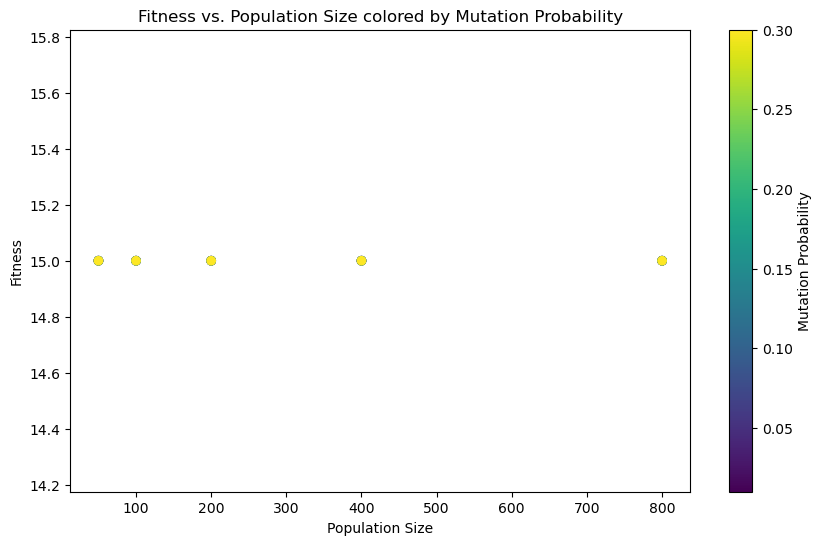

In [33]:
# Fitness vs Population Size colored by Mutation Probability Visualization
pop_sizes, mut_probs, fitnesses = zip(*results)
plt.figure(figsize=(10,6))
plt.scatter(pop_sizes, fitnesses, c=mut_probs, cmap='viridis')
plt.colorbar(label='Mutation Probability')
plt.xlabel('Population Size')
plt.ylabel('Fitness')
plt.title('Fitness vs. Population Size colored by Mutation Probability')
plt.show()

In [3]:
#MIMIC
#Tuning Hyperparameters using a reduced grid:
param_grid = {
    'pop_size': [100, 400, 800],
    'keep_pct': [0.2, 0.3, 0.4]
}

best_fitness = -np.inf  # initialize with a very small value
best_params = {}
all_results = []

# Using early stopping and parallelization for efficiency:
def evaluate_parameters(params):
    best_state, current_best_fitness, curve = mlrose_hiive.mimic(
        problem,
        curve=True,
        random_state=42,
        max_attempts=10,  # Early stopping after 10 unsuccessful attempts
        **params
    )
    return {'pop_size': params['pop_size'], 'keep_pct': params['keep_pct'], 'best_fitness': current_best_fitness}

all_results = Parallel(n_jobs=-1)(delayed(evaluate_parameters)(params) for params in ParameterGrid(param_grid))

# Extracting best parameters:
best_result = max(all_results, key=lambda x: x['best_fitness'])
best_fitness = best_result['best_fitness']
best_params = {'pop_size': best_result['pop_size'], 'keep_pct': best_result['keep_pct']}

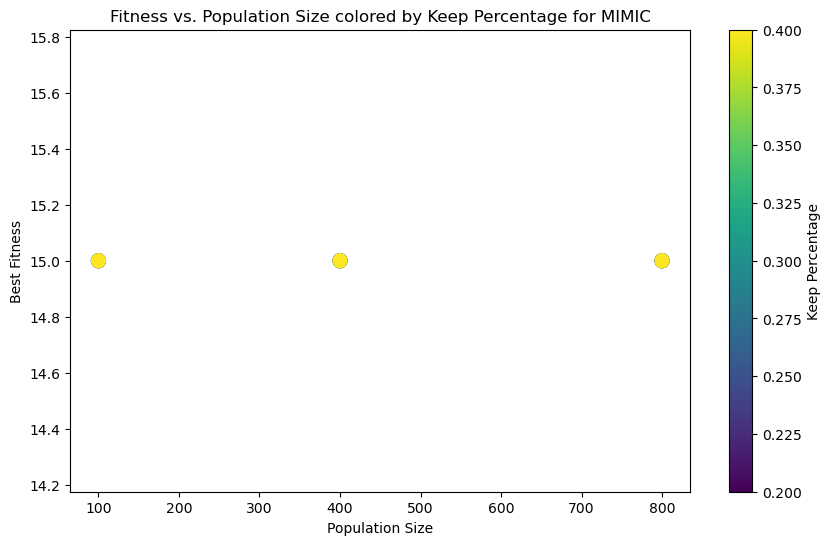

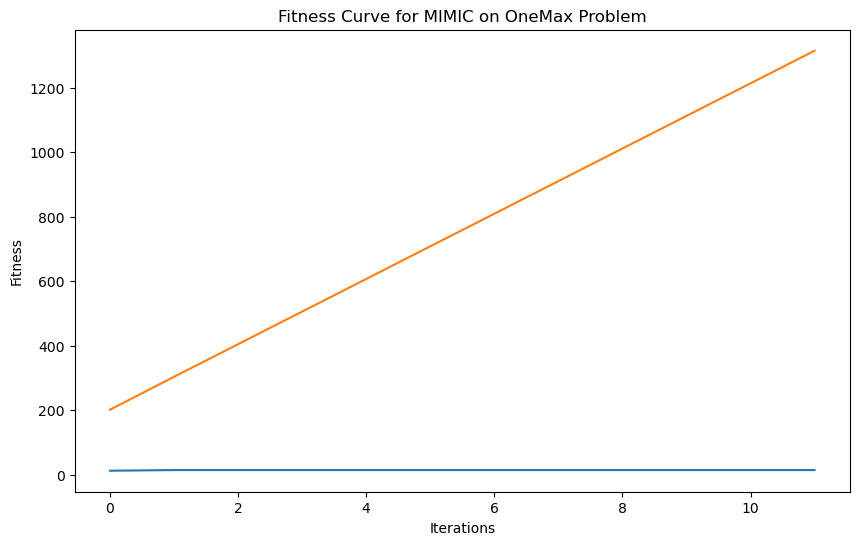

Elapsed Time: 0.8876049518585205 seconds
Best Parameters: {'pop_size': 100, 'keep_pct': 0.2}
Best Fitness: 15.0


In [4]:
# Time Analysis:
start_time = time.time()
best_state, best_fitness, fitness_curve = mlrose_hiive.mimic(
    problem,
    curve=True,
    random_state=42,
    max_attempts=10,  # Early stopping
    **best_params
)
end_time = time.time()
elapsed_time = end_time - start_time

# Population and Keep Rate Analysis:
pop_sizes = [result['pop_size'] for result in all_results]
keep_pcts = [result['keep_pct'] for result in all_results]
fitnesses = [result['best_fitness'] for result in all_results]

plt.figure(figsize=(10, 6))
plt.scatter(pop_sizes, fitnesses, c=keep_pcts, cmap='viridis', s=100)
plt.colorbar(label='Keep Percentage')
plt.xlabel("Population Size")
plt.ylabel("Best Fitness")
plt.title("Fitness vs. Population Size colored by Keep Percentage for MIMIC")
plt.show()

# Consistency and Convergence Analysis:
plt.figure(figsize=(10, 6))
plt.plot(fitness_curve)
plt.title("Fitness Curve for MIMIC on OneMax Problem")
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.show()

print(f"Elapsed Time: {elapsed_time} seconds")
print(f"Best Parameters: {best_params}")
print(f"Best Fitness: {best_fitness}")


Results for Random Seed 42 across 10 runs:
Mean: 15.0
Median: 15.0
Min: 15.0
Max: 15.0
Standard Deviation: 0.0

Results for Random Seed 100 across 10 runs:
Mean: 15.0
Median: 15.0
Min: 15.0
Max: 15.0
Standard Deviation: 0.0

Results for Random Seed 200 across 10 runs:
Mean: 15.0
Median: 15.0
Min: 15.0
Max: 15.0
Standard Deviation: 0.0


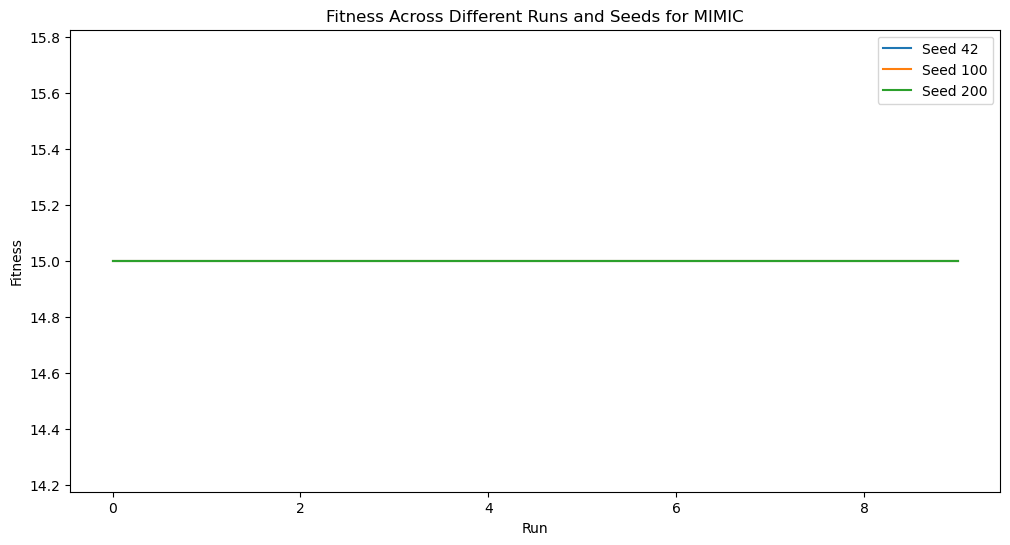

In [5]:
num_runs = 10
seeds = [42, 100, 200]  # Three random seeds
all_run_results = []

for seed in seeds:
    run_results = []
    for run in range(num_runs):
        _, current_best_fitness, _ = mlrose_hiive.mimic(
            problem,
            curve=False,
            random_state=seed,
            max_attempts=10,  # Early stopping
            **best_params
        )
        run_results.append(current_best_fitness)
    all_run_results.append(run_results)

    print(f"\nResults for Random Seed {seed} across {num_runs} runs:")
    print(f"Mean: {np.mean(run_results)}")
    print(f"Median: {np.median(run_results)}")
    print(f"Min: {np.min(run_results)}")
    print(f"Max: {np.max(run_results)}")
    print(f"Standard Deviation: {np.std(run_results)}")

# Let's also plot the results for visualization
plt.figure(figsize=(12, 6))
for idx, seed in enumerate(seeds):
    plt.plot(all_run_results[idx], label=f'Seed {seed}')
plt.legend()
plt.xlabel('Run')
plt.ylabel('Fitness')
plt.title('Fitness Across Different Runs and Seeds for MIMIC')
plt.show()

In [3]:
#Four Peaks

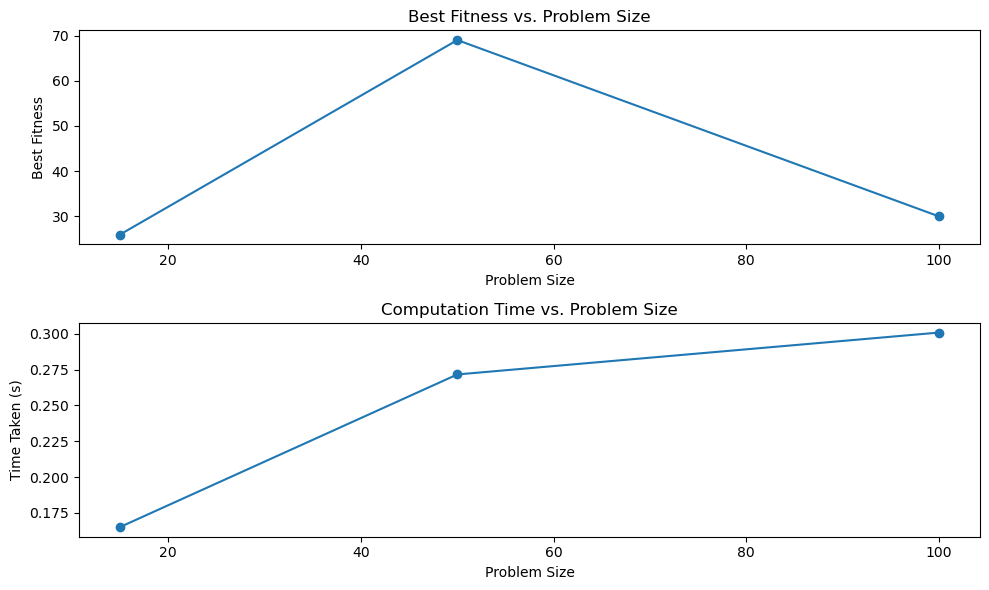

In [3]:
# Define problem sizes
problem_sizes = [15, 50,100]

# Lists to store results
best_fitnesses = []
times_taken = []

for size in problem_sizes:
    # Initialize the Four Peaks problem
    fitness = mlrose_hiive.FourPeaks(t_pct=0.15)
    problem = mlrose_hiive.DiscreteOpt(length=size, fitness_fn=fitness, maximize=True, max_val=2)
    
    # Run GA
    start_time = time.time()
    best_state, best_fitness, _ = mlrose_hiive.genetic_alg(problem, random_state=42)  # Adjusted this line
    end_time = time.time()
    
    # Collect results
    best_fitnesses.append(best_fitness)
    times_taken.append(end_time - start_time)

# Visualization of Results
plt.figure(figsize=(10, 6))

# Plotting fitness vs. problem size
plt.subplot(2, 1, 1)
plt.plot(problem_sizes, best_fitnesses, '-o')
plt.xlabel('Problem Size')
plt.ylabel('Best Fitness')
plt.title('Best Fitness vs. Problem Size')

# Plotting computation time vs. problem size
plt.subplot(2, 1, 2)
plt.plot(problem_sizes, times_taken, '-o')
plt.xlabel('Problem Size')
plt.ylabel('Time Taken (s)')
plt.title('Computation Time vs. Problem Size')

plt.tight_layout()
plt.show()


In [12]:
#GA
# Initialize the Four Peaks problem
problem_size = 50  # Mid-size
fitness = mlrose_hiive.FourPeaks(t_pct=0.15)
problem = mlrose_hiive.DiscreteOpt(length=problem_size, fitness_fn=fitness, maximize=True, max_val=2)

# Initial parameters for GA
population_sizes = [50, 100, 200, 400, 800]
mutation_probs = [0.01, 0.05, 0.1, 0.2, 0.3]

best_fitness = -np.inf
best_params = None

results = []
times = []
fevals_per_second = []

for pop in population_sizes:
    for mut in mutation_probs:
        start_time = time.time()
        _, best_fitness_run, curve = mlrose_hiive.genetic_alg(
            problem,
            pop_size=pop,
            mutation_prob=mut,
            random_state=42,
            curve=True
        )
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        feval_rate = len(curve) / elapsed_time
        fevals_per_second.append(feval_rate)

        times.append(elapsed_time)
        
        if best_fitness_run > best_fitness:
            best_fitness = best_fitness_run
            best_params = {"pop_size": pop, "mutation_prob": mut}
        results.append((pop, mut, best_fitness_run))

Average fevals per second: 156.0515034454637
Best fitness achieved: 91.0
Best parameters: {'pop_size': 200, 'mutation_prob': 0.2}
Average time taken: 0.7422655773162842 seconds
Average function evaluations per second: 156.0515034454637
Results across 10 runs:
Mean: 84.1
Median: 85.5
Min: 74.0
Max: 91.0
Standard Deviation: 6.425729530566938


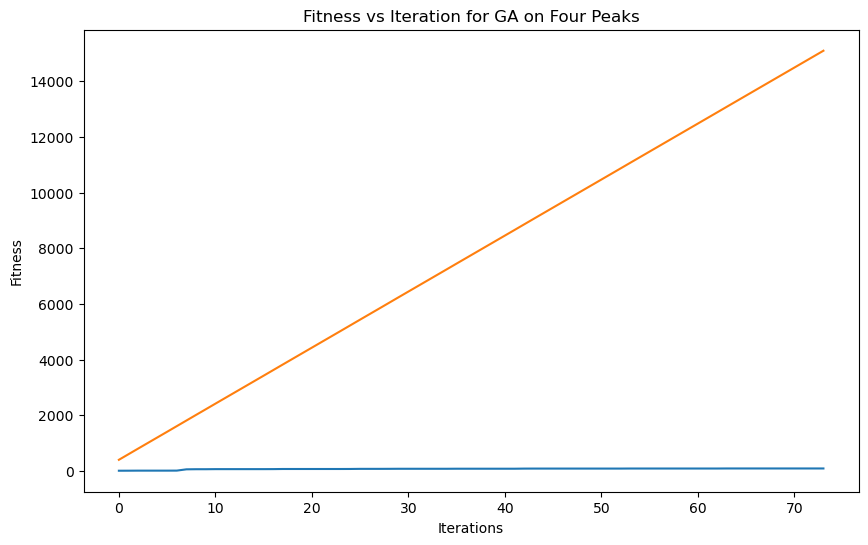

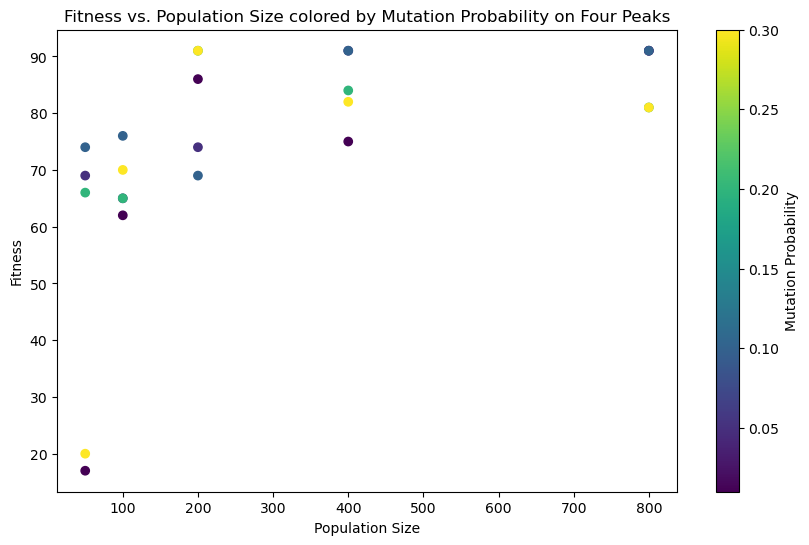

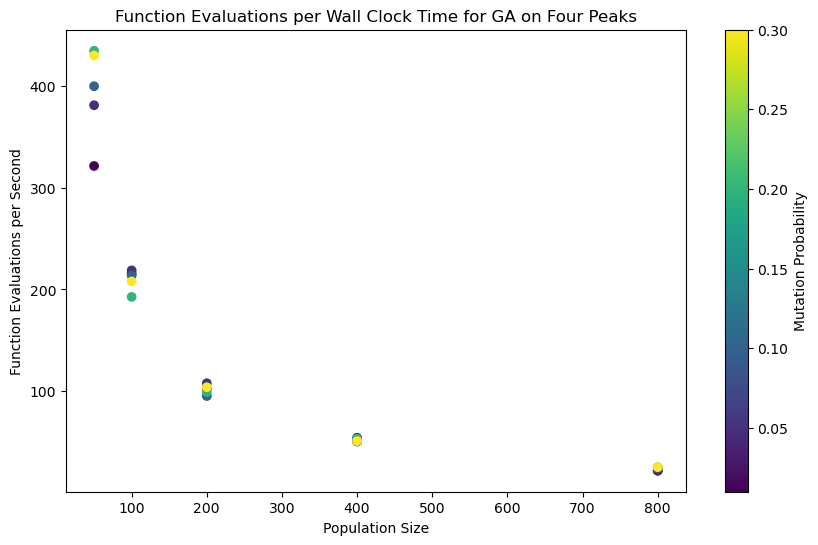

In [13]:
# Results display
# Print average fevals/wall clock time
print(f"Average fevals per second: {np.mean(fevals_per_second)}")
print(f"Best fitness achieved: {best_fitness}")
print(f"Best parameters: {best_params}")
print(f"Average time taken: {np.mean(times)} seconds")
print(f"Average function evaluations per second: {np.mean(fevals_per_second)}")

# Consistency and Variance Analysis with different initial states
num_runs = 10
run_results = []

for i in range(num_runs):
    _, best_fitness_run, _ = mlrose_hiive.genetic_alg(
        problem,
        pop_size=best_params["pop_size"],
        mutation_prob=best_params["mutation_prob"],
        random_state=42 + i
    )
    run_results.append(best_fitness_run)

print(f"Results across {num_runs} runs:")
print(f"Mean: {np.mean(run_results)}")
print(f"Median: {np.median(run_results)}")
print(f"Min: {np.min(run_results)}")
print(f"Max: {np.max(run_results)}")
print(f"Standard Deviation: {np.std(run_results)}")

# Fitness vs Iteration Visualization
state, best_fitness, curve = mlrose_hiive.genetic_alg(
    problem,
    pop_size=best_params["pop_size"],
    mutation_prob=best_params["mutation_prob"],
    random_state=42,
    curve=True
)
iterations = np.arange(len(curve))
plt.figure(figsize=(10,6))
plt.plot(iterations, curve)
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.title('Fitness vs Iteration for GA on Four Peaks')
plt.show()

# Fitness vs Population Size colored by Mutation Probability Visualization
pop_sizes, mut_probs, fitnesses = zip(*results)
plt.figure(figsize=(10,6))
plt.scatter(pop_sizes, fitnesses, c=mut_probs, cmap='viridis')
plt.colorbar(label='Mutation Probability')
plt.xlabel('Population Size')
plt.ylabel('Fitness')
plt.title('Fitness vs. Population Size colored by Mutation Probability on Four Peaks')
plt.show()


expanded_pop_sizes = [p for p in population_sizes for _ in mutation_probs]
expanded_mut_probs = mutation_probs * len(population_sizes)

plt.figure(figsize=(10,6))
plt.scatter(expanded_pop_sizes, fevals_per_second, c=expanded_mut_probs, cmap='viridis')
plt.colorbar(label='Mutation Probability')
plt.xlabel('Population Size')
plt.ylabel('Function Evaluations per Second')
plt.title('Function Evaluations per Wall Clock Time for GA on Four Peaks')
plt.show()

In [2]:
#RHC

In [6]:
# Define different problem sizes
problem_sizes = [10, 50, 100]

# Store best results for each size
best_size_results = {}

for problem_size in problem_sizes:
    # Initialize the Four Peaks problem
    fitness = mlrose_hiive.FourPeaks(t_pct=0.15)
    problem = mlrose_hiive.DiscreteOpt(length=problem_size, fitness_fn=fitness, maximize=True, max_val=2)
    init_state = np.random.randint(2, size=problem_size)

    # Hyperparameter tuning
    param_grid = {
        'max_attempts': [10, 100],
        'max_iters': [500, 1000],
        'restarts': [5, 10]
    }

    best_fitness = -np.inf  # initialize with a very small value
    best_params = {}

    for params in ParameterGrid(param_grid):
        _, current_best_fitness, _ = mlrose_hiive.random_hill_climb(
            problem,
            init_state=init_state,
            curve=False,
            random_state=42,
            **params
        )

        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_params = params

    best_size_results[problem_size] = {'best_fitness': best_fitness, 'best_params': best_params}

# Choose the best problem size based on maximum fitness
best_problem_size = max(best_size_results, key=lambda k: best_size_results[k]['best_fitness'])
print(f"Best problem size based on fitness: {best_problem_size}")

Best problem size based on fitness: 50


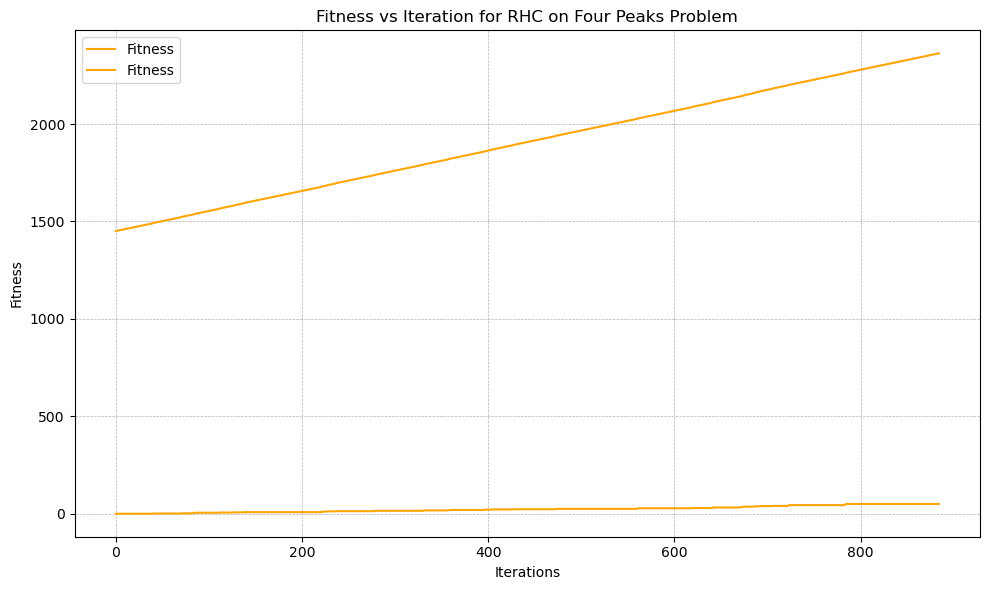

In [7]:
# Continue the analysis with the best problem size
fitness = mlrose_hiive.FourPeaks(t_pct=0.15)
problem = mlrose_hiive.DiscreteOpt(length=best_problem_size, fitness_fn=fitness, maximize=True, max_val=2)
init_state = np.random.randint(2, size=best_problem_size)

# Run RHC with best hyperparameters for the selected problem size
best_params = best_size_results[best_problem_size]['best_params']
best_state, best_fitness, fitness_curve = mlrose_hiive.random_hill_climb(
    problem,
    init_state=init_state,
    curve=True,
    random_state=42,
    **best_params
)

# Fitness curve plot
plt.figure(figsize=(10,6))
plt.plot(fitness_curve, label="Fitness", color='orange')
plt.title("Fitness vs Iteration for RHC on Four Peaks Problem")
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [8]:
# Time analysis
start_time = time.time()
mlrose_hiive.random_hill_climb(
    problem,
    init_state=init_state,
    curve=False,
    random_state=42,
    **best_params
)
end_time = time.time()
print(f"Time taken for RHC: {end_time - start_time:.5f} seconds")

Time taken for RHC: 0.05345 seconds


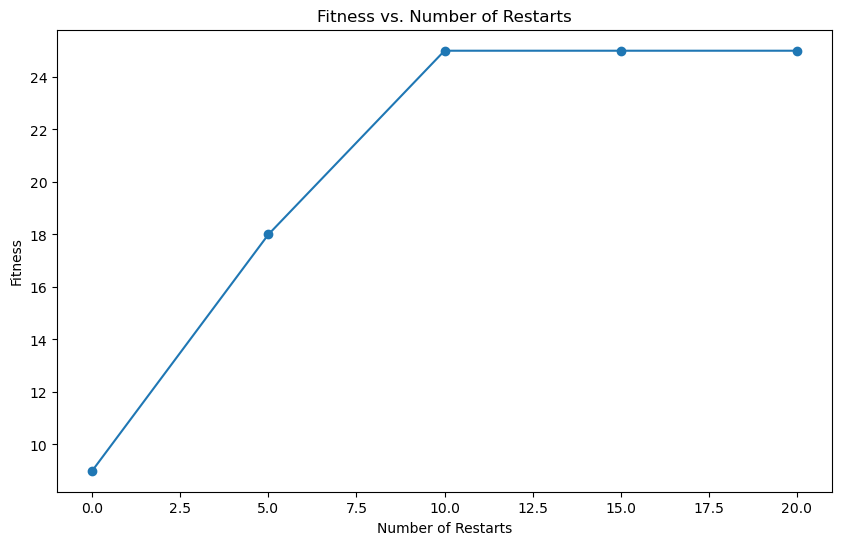

Results across 10 runs:
Mean: 37.8
Median: 39.0
Min: 13.0
Max: 50.0
Standard Deviation: 11.443775600735975
Results with different initial states:
Mean: 36.6
Median: 38.0
Min: 19.0
Max: 50.0
Standard Deviation: 12.611106216347558


In [11]:
# Regenerate init_state based on the best_problem_size
init_state = np.random.randint(2, size=best_problem_size)

# 5. Restart Analysis
restarts_range = [0, 5, 10, 15, 20]
fitnesses = []

for restart in restarts_range:
    _, current_best_fitness, _ = mlrose_hiive.random_hill_climb(
        problem,
        init_state=init_state,
        curve=False,
        random_state=42,
        max_attempts=best_params['max_attempts'],
        max_iters=best_params['max_iters'],
        restarts=restart
    )
    fitnesses.append(current_best_fitness)

plt.figure(figsize=(10,6))
plt.plot(restarts_range, fitnesses, marker='o')
plt.title("Fitness vs. Number of Restarts")
plt.xlabel("Number of Restarts")
plt.ylabel("Fitness")
plt.show()

# 6. Consistency Check
num_runs = 10
results = []

for i in range(num_runs):
    _, best_fitness_run, _ = mlrose_hiive.random_hill_climb(
        problem, 
        init_state=None,
        curve=False,
        random_state=42 + i,
        **best_params
    )
    results.append(best_fitness_run)

print(f"Results across {num_runs} runs:")
print(f"Mean: {np.mean(results)}")
print(f"Median: {np.median(results)}")
print(f"Min: {np.min(results)}")
print(f"Max: {np.max(results)}")
print(f"Standard Deviation: {np.std(results)}")

# 7. Already done above with the fitness curve plot

# 8. Initial State Sensitivity
# It's similar to the consistency check, but with varying initial states rather than random seeds.

results_init = []

for i in range(num_runs):
    random_init = np.random.randint(2, size=best_problem_size)
    _, best_fitness_run, _ = mlrose_hiive.random_hill_climb(
        problem,
        init_state=random_init,
        curve=False,
        random_state=42,
        **best_params
    )
    results_init.append(best_fitness_run)

print(f"Results with different initial states:")
print(f"Mean: {np.mean(results_init)}")
print(f"Median: {np.median(results_init)}")
print(f"Min: {np.min(results_init)}")
print(f"Max: {np.max(results_init)}")
print(f"Standard Deviation: {np.std(results_init)}")


Average fevals per second: 20202.474763639188
Average time taken: 0.042624378204345705 seconds
Average function evaluations per second: 20202.474763639188


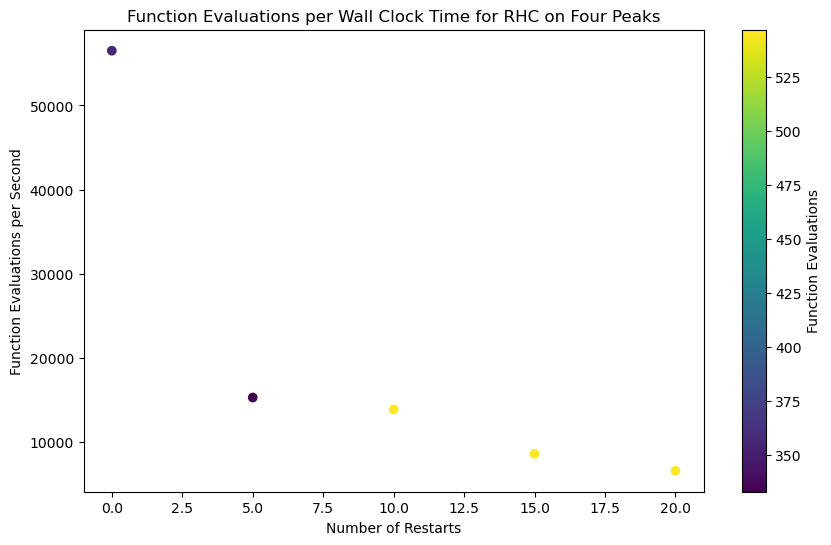

In [12]:
# Initialize lists to store metrics
times = []
fevals = []
fevals_per_second = []

# 5. Restart Analysis
restarts_range = [0, 5, 10, 15, 20]
fitnesses = []

for restart in restarts_range:
    start_time = time.time()
    _, current_best_fitness, curve = mlrose_hiive.random_hill_climb(
        problem,
        init_state=init_state,
        curve=True,
        random_state=42,
        max_attempts=best_params['max_attempts'],
        max_iters=best_params['max_iters'],
        restarts=restart
    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    times.append(elapsed_time)
    fevals.append(len(curve))
    fevals_per_second.append(len(curve) / elapsed_time)
    fitnesses.append(current_best_fitness)

# Print and Plot metrics
print(f"Average fevals per second: {np.mean(fevals_per_second)}")
print(f"Average time taken: {np.mean(times)} seconds")
print(f"Average function evaluations per second: {np.mean(fevals_per_second)}")

plt.figure(figsize=(10,6))
plt.scatter(restarts_range, fevals_per_second, c=fevals, cmap='viridis')
plt.colorbar(label='Function Evaluations')
plt.xlabel('Number of Restarts')
plt.ylabel('Function Evaluations per Second')
plt.title('Function Evaluations per Wall Clock Time for RHC on Four Peaks')
plt.show()

In [13]:
#SA

In [2]:
# Define different problem sizes
problem_sizes = [15, 50, 100]

# Store best results for each size
best_size_results = {}

for problem_size in problem_sizes:
    # Initialize the Four Peaks problem
    fitness = mlrose_hiive.FourPeaks(t_pct=0.15)
    problem = mlrose_hiive.DiscreteOpt(length=problem_size, fitness_fn=fitness, maximize=True, max_val=2)
    init_state = np.random.randint(2, size=problem_size)

    # Define a range for temperatures
    temperatures = [0.1, 0.5, 1.0, 5.0, 10.0]

    # Hyperparameter tuning
    param_grid = {
        'schedule': [mlrose_hiive.ExpDecay(init_temp=temp) for temp in temperatures],
        'max_attempts': [10, 100],
        'max_iters': [500, 1000]
    }

    best_fitness = -np.inf  # initialize with a very small value
    best_params = {}

    for params in ParameterGrid(param_grid):
        _, current_best_fitness, _ = mlrose_hiive.simulated_annealing(
            problem,
            init_state=init_state,
            curve=False,
            random_state=42,
            **params
        )

        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_params = params

    best_size_results[problem_size] = {'best_fitness': best_fitness, 'best_params': best_params}

# Choose the best problem size based on maximum fitness
best_problem_size = max(best_size_results, key=lambda k: best_size_results[k]['best_fitness'])
print(f"Best problem size based on fitness: {best_problem_size}")
print("Parameters for best problem size:", best_size_results[best_problem_size])

Best problem size based on fitness: 50
Parameters for best problem size: {'best_fitness': 50.0, 'best_params': {'max_attempts': 100, 'max_iters': 1000, 'schedule': ExpDecay(init_temp=0.1, exp_const=0.005, min_temp=0.001)}}


In [5]:
# Using the best problem size and parameters from your previous run
problem_size = 50

# Initialize the Four Peaks problem
fitness = mlrose_hiive.FourPeaks(t_pct=0.15)
problem = mlrose_hiive.DiscreteOpt(length=problem_size, fitness_fn=fitness, maximize=True, max_val=2)

# Best parameters
best_params = {'max_attempts': 100, 'max_iters': 1000}
decay = mlrose_hiive.ExpDecay(init_temp=0.1, exp_const=0.005, min_temp=0.001)

### Run Algorithm ###

start_time = time.time()

best_state, best_fitness, fitness_curve = mlrose_hiive.simulated_annealing(
    problem,
    schedule=decay,
    max_attempts=best_params['max_attempts'],
    max_iters=best_params['max_iters'],
    curve=True,
    random_state=42
)

end_time = time.time()

print(f"Best State: {best_state}")
print(f"Best Fitness: {best_fitness}")

Best State: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 0 0 0 0 0 0]
Best Fitness: 42.0


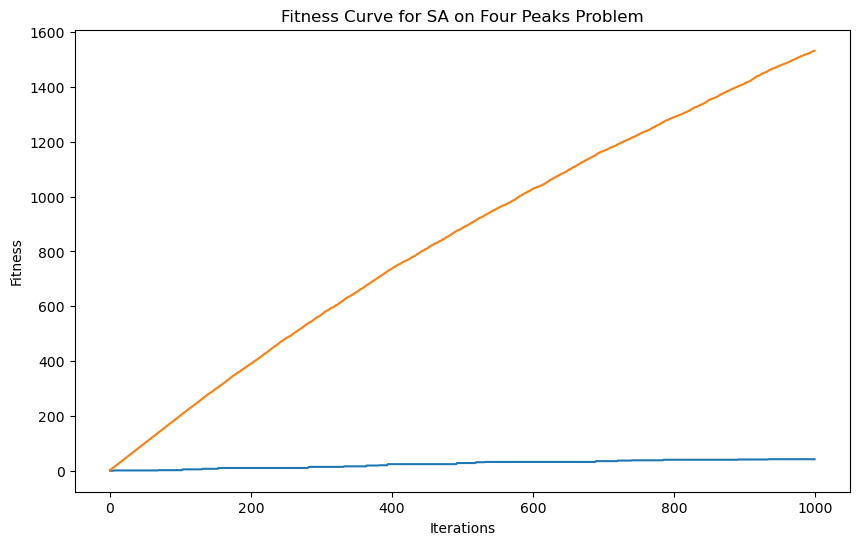

Execution Time: 0.01972484588623047 seconds
Function Evaluations: 1000
Wall-clock time for those evaluations: 0.019881248474121094 seconds
Results across 10 runs:
Mean: 54.4
Median: 42.5
Min: 31.0
Max: 91.0
Standard Deviation: 23.337523433303716


In [14]:
plt.figure(figsize=(10,6))
plt.plot(fitness_curve)
plt.title("Fitness Curve for SA on Four Peaks Problem")
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.show()

### Time Analysis ###
print(f"Execution Time: {end_time - start_time} seconds")

# Function evaluations vs wall-clock time analysis
start_time = time.time()
_, _, fitness_curve = mlrose_hiive.simulated_annealing(
    problem,
    schedule=decay,
    max_attempts=best_params['max_attempts'],
    max_iters=best_params['max_iters'],
    curve=True,
    random_state=42
)
end_time = time.time()

fevals = len(fitness_curve)
print(f"Function Evaluations: {fevals}")
print(f"Wall-clock time for those evaluations: {end_time - start_time} seconds")

# Consistency Across Runs
num_runs = 10  # Adjust this based on your computational capability
results = []

for i in range(num_runs):
    _, best_fitness_run, _ = mlrose_hiive.simulated_annealing(
        problem,
        schedule=decay,
        max_attempts=best_params['max_attempts'],
        max_iters=best_params['max_iters'],
        random_state=42 + i
    )
    results.append(best_fitness_run)

print(f"Results across {num_runs} runs:")
print(f"Mean: {np.mean(results)}")
print(f"Median: {np.median(results)}")
print(f"Min: {np.min(results)}")
print(f"Max: {np.max(results)}")
print(f"Standard Deviation: {np.std(results)}")

In [7]:
# Consistency Across Different Initial States
results_init = []

for i in range(num_runs):
    random_init = np.random.randint(2, size=problem_size)
    _, best_fitness_run, _ = mlrose_hiive.simulated_annealing(
        problem,
        init_state=random_init,
        schedule=decay,
        max_attempts=best_params['max_attempts'],
        max_iters=best_params['max_iters'],
        random_state=42
    )

In [8]:
results_init.append(best_fitness_run)

In [9]:
print(f"Results across {num_runs} different initial states:")
print(f"Mean: {np.mean(results_init)}")
print(f"Median: {np.median(results_init)}")
print(f"Min: {np.min(results_init)}")
print(f"Max: {np.max(results_init)}")
print(f"Standard Deviation: {np.std(results_init)}")

Results across 5 different initial states:
Mean: 50.0
Median: 50.0
Min: 50.0
Max: 50.0
Standard Deviation: 0.0


In [12]:
# Fevals/wall-clock time
times = []
feval_times = []

for i in range(num_runs):
    start_time = time.time()
    _, _, fitness_curve_run = mlrose_hiive.simulated_annealing(
        problem,
        schedule=decay,
        max_attempts=best_params['max_attempts'],
        max_iters=best_params['max_iters'],
        curve=True,
        random_state=42 + i
    )
    end_time = time.time()

    run_time = end_time - start_time
    fevals_run = len(fitness_curve_run)

    times.append(run_time)
    feval_times.append(fevals_run / run_time)  # function evaluations per second

print(f"Mean function evaluations per second: {np.mean(feval_times)}")
print(f"Median function evaluations per second: {np.median(feval_times)}")
print(f"Min function evaluations per second: {np.min(feval_times)}")
print(f"Max function evaluations per second: {np.max(feval_times)}")
print(f"Standard Deviation of function evaluations per second: {np.std(feval_times)}")


Mean function evaluations per second: 45032.329113705
Median function evaluations per second: 44822.62622597653
Min function evaluations per second: 40059.444900765986
Max function evaluations per second: 50697.48102306242
Standard Deviation of function evaluations per second: 3382.7955909904585


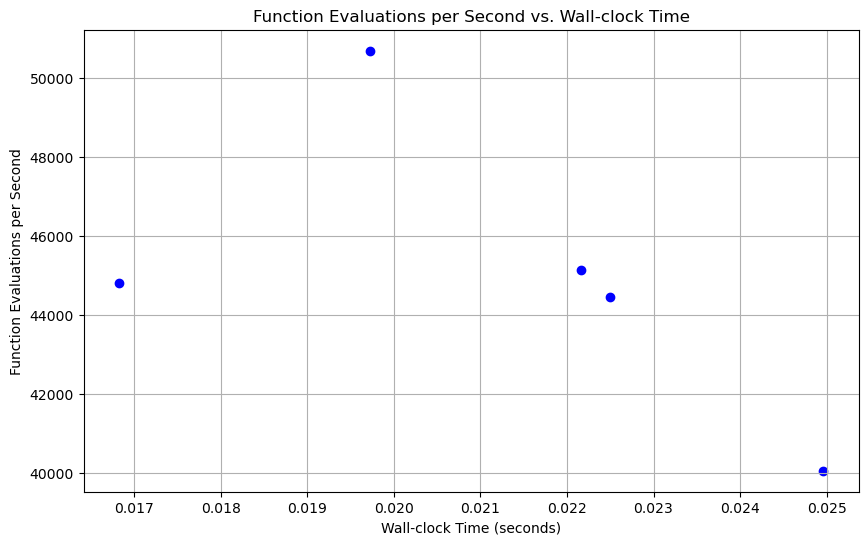

In [13]:
# Plotting fevals/wall-clock time
plt.figure(figsize=(10,6))
plt.scatter(times, feval_times, marker='o', color='blue')
plt.title("Function Evaluations per Second vs. Wall-clock Time")
plt.xlabel("Wall-clock Time (seconds)")
plt.ylabel("Function Evaluations per Second")
plt.grid(True)
plt.show()

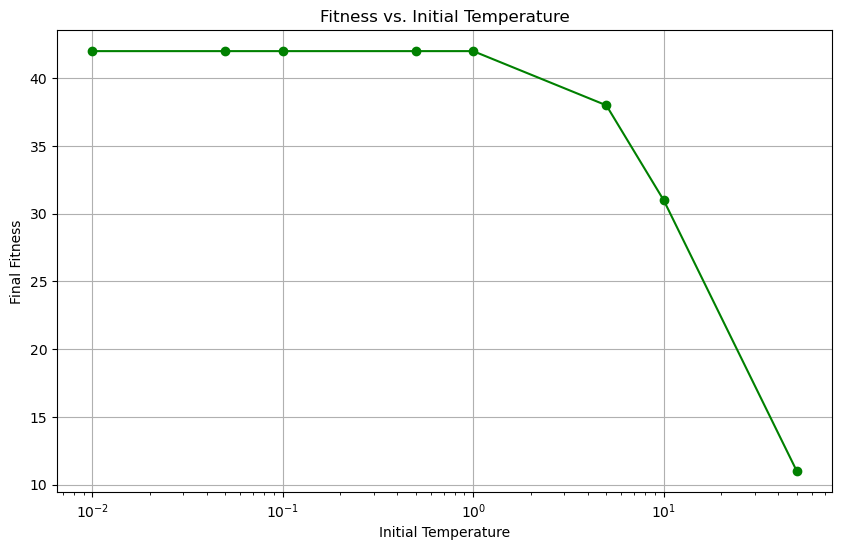

In [15]:
# Varying initial temperatures
init_temps = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]
fitness_results = []

for temp in init_temps:
    decay = mlrose_hiive.ExpDecay(init_temp=temp, exp_const=0.005, min_temp=0.001)
    _, best_fitness_temp, _ = mlrose_hiive.simulated_annealing(
        problem,
        schedule=decay,
        max_attempts=best_params['max_attempts'],
        max_iters=best_params['max_iters'],
        random_state=42
    )
    fitness_results.append(best_fitness_temp)

# Plotting fitness vs initial temperature
plt.figure(figsize=(10,6))
plt.plot(init_temps, fitness_results, marker='o', linestyle='-', color='green')
plt.title("Fitness vs. Initial Temperature")
plt.xlabel("Initial Temperature")
plt.ylabel("Final Fitness")
plt.grid(True)
plt.xscale("log")  # Logarithmic scale can make it easier to observe results if init_temps vary widely.
plt.show()

In [16]:
#MIMIC

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from mlrose_hiive import DiscreteOpt, FourPeaks, mimic
from joblib import Parallel, delayed
from sklearn.model_selection import ParameterGrid

In [8]:
problem_size = 50
t_pct = 0.1

# Define fitness function object
fitness = FourPeaks(t_pct=t_pct)

# Define the optimization problem object
problem = DiscreteOpt(length=problem_size, fitness_fn=fitness, maximize=True, max_val=2)

# Hyperparameter tuning:
param_grid = {
    'pop_size': [100, 400],
    'keep_pct': [0.2, 0.3]
}

def evaluate_parameters_with_time(params):
    start_time = time.time()
    best_state, current_best_fitness, curve = mimic(
        problem,
        curve=True,
        random_state=42,
        max_attempts=10,
        **params
    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    return {
        'pop_size': params['pop_size'],
        'keep_pct': params['keep_pct'],
        'best_fitness': current_best_fitness,
        'elapsed_time': elapsed_time,
        'curve': curve
    }

all_results_time = Parallel(n_jobs=-1)(delayed(evaluate_parameters_with_time)(params) for params in ParameterGrid(param_grid))

# Extracting best parameters:
best_result = max(all_results_time, key=lambda x: x['best_fitness'])
best_params = {'pop_size': best_result['pop_size'], 'keep_pct': best_result['keep_pct']}

print(f"Best Parameters: {best_params}")
print(f"Best Fitness: {best_result['best_fitness']}")
print(f"Wall-Clock Time for Best Params: {best_result['elapsed_time']} seconds")

Best Parameters: {'pop_size': 400, 'keep_pct': 0.2}
Best Fitness: 75.0
Wall-Clock Time for Best Params: 26.454230070114136 seconds


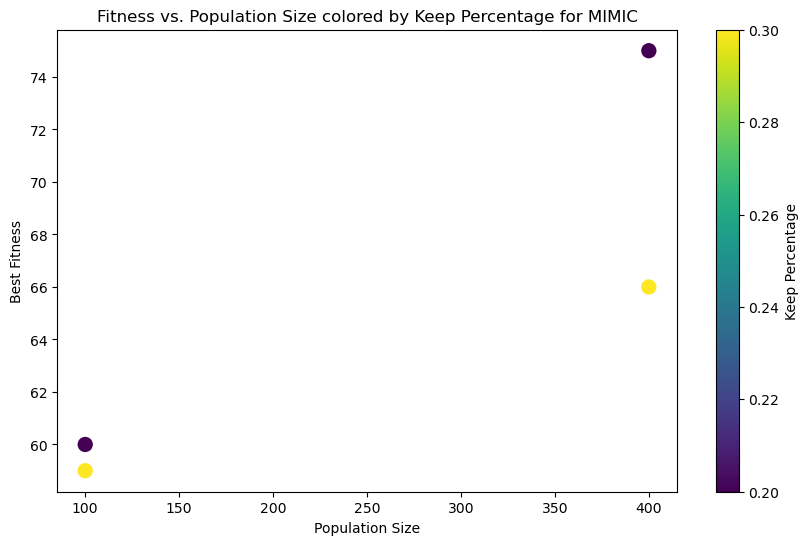

In [4]:
# Visualizing Population and Keep Rate Analysis:
pop_sizes = [result['pop_size'] for result in all_results_time]
keep_pcts = [result['keep_pct'] for result in all_results_time]
fitnesses = [result['best_fitness'] for result in all_results_time]

plt.figure(figsize=(10, 6))
plt.scatter(pop_sizes, fitnesses, c=keep_pcts, cmap='viridis', s=100)
plt.colorbar(label='Keep Percentage')
plt.xlabel("Population Size")
plt.ylabel("Best Fitness")
plt.title("Fitness vs. Population Size colored by Keep Percentage for MIMIC")
plt.show()

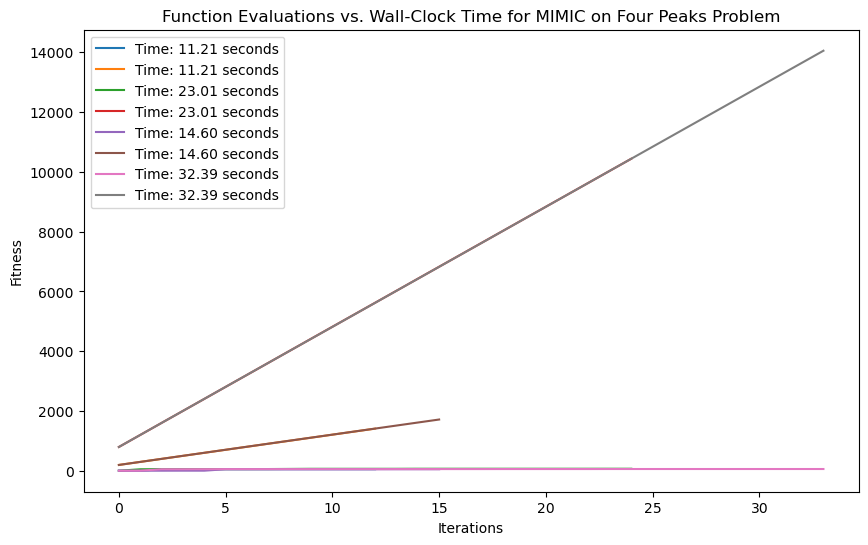

In [5]:
# Visualize Function Evaluations vs. Wall-Clock Time:
fevals_times = [result['elapsed_time'] for result in all_results_time]
fevals_curves = [result['curve'] for result in all_results_time]

plt.figure(figsize=(10, 6))
for idx, curve in enumerate(fevals_curves):
    plt.plot(curve, label=f'Time: {fevals_times[idx]:.2f} seconds')
plt.legend()
plt.title("Function Evaluations vs. Wall-Clock Time for MIMIC on Four Peaks Problem")
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.show()

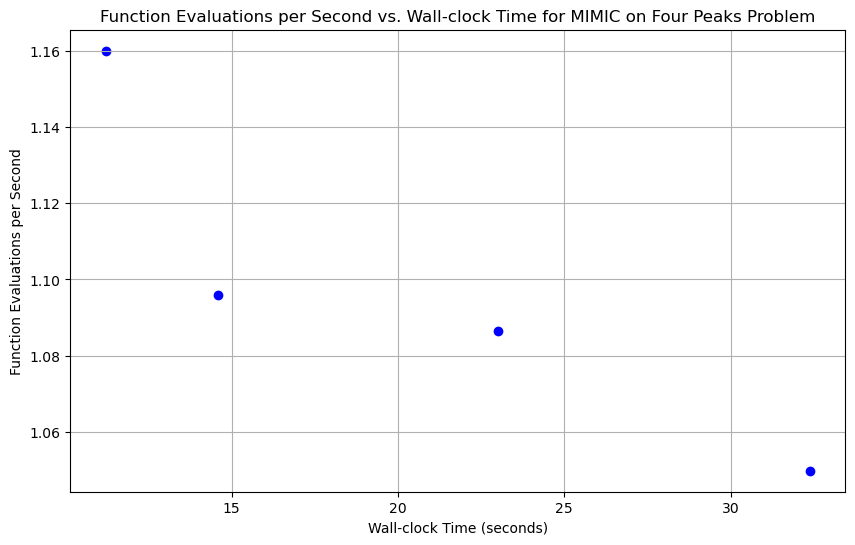

In [10]:
# Compute the number of function evaluations per second for each set of parameters:
feval_per_second = [len(curve) / elapsed for curve, elapsed in zip(fevals_curves, fevals_times)]

# Plotting fevals/wall-clock time:
plt.figure(figsize=(10,6))
plt.scatter(fevals_times, feval_per_second, marker='o', color='blue')
plt.title("Function Evaluations per Second vs. Wall-clock Time for MIMIC on Four Peaks Problem")
plt.xlabel("Wall-clock Time (seconds)")
plt.ylabel("Function Evaluations per Second")
plt.grid(True)
plt.show()

In [6]:
# Consistency Across Runs:
num_runs = 5  # reduced runs for computational resource constraints
seeds = [42, 100]

all_run_results = []
all_execution_times = []

for seed in seeds:
    run_results = []
    execution_times = []
    for run in range(num_runs):
        start_time = time.time()
        _, current_best_fitness, _ = mimic(
            problem,
            curve=False,
            random_state=seed,
            max_attempts=10,
            **best_params
        )
        end_time = time.time()
        execution_times.append(end_time - start_time)
        run_results.append(current_best_fitness)
    
    all_execution_times.append(np.mean(execution_times))
    all_run_results.append(run_results)

    print(f"\nResults for Random Seed {seed} across {num_runs} runs:")
    print(f"Mean: {np.mean(run_results)}")
    print(f"Median: {np.median(run_results)}")
    print(f"Min: {np.min(run_results)}")
    print(f"Max: {np.max(run_results)}")
    print(f"Standard Deviation: {np.std(run_results)}")


Results for Random Seed 42 across 5 runs:
Mean: 75.0
Median: 75.0
Min: 75.0
Max: 75.0
Standard Deviation: 0.0

Results for Random Seed 100 across 5 runs:
Mean: 80.0
Median: 80.0
Min: 80.0
Max: 80.0
Standard Deviation: 0.0


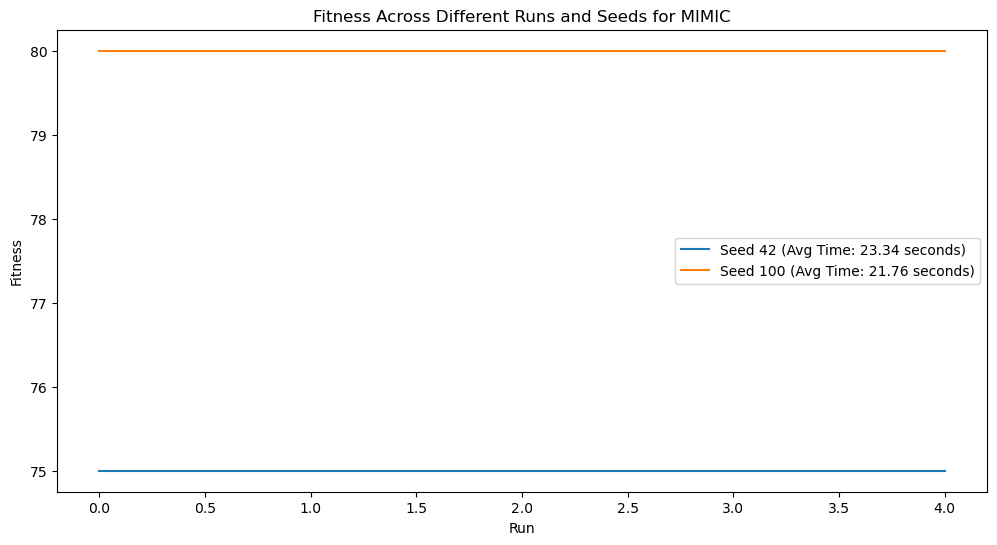

In [7]:
# Plotting results for visualization:
plt.figure(figsize=(12, 6))
for idx, seed in enumerate(seeds):
    plt.plot(all_run_results[idx], label=f'Seed {seed} (Avg Time: {all_execution_times[idx]:.2f} seconds)')
plt.legend()
plt.xlabel('Run')
plt.ylabel('Fitness')
plt.title('Fitness Across Different Runs and Seeds for MIMIC')
plt.show()

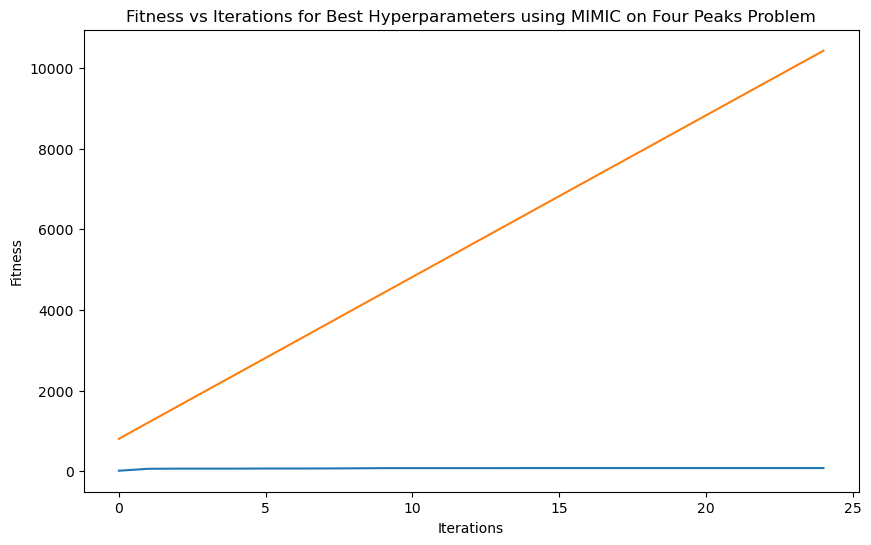

In [9]:
best_curve = best_result['curve']

plt.figure(figsize=(10, 6))
plt.plot(best_curve)
plt.title("Fitness vs Iterations for Best Hyperparameters using MIMIC on Four Peaks Problem")
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.show()

In [ ]:
#Traveling Sales Person